In [1]:
from flash_ansr.models import FlashANSRTransformer
from flash_ansr import get_path, FlashANSRDataset
from flash_ansr.train.train import ContrastiveLoss

import schedulefree
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from umap import UMAP

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def smooth_w_boundaries(x, window_len=101):
    if window_len % 2 == 0:
        window_len += 1

    if window_len < 3:
        return x

    kernel = np.hanning(window_len)
    kernel /= kernel.sum()

    # Convolve the middle part with valid mode
    x_convolved_middle = np.convolve(x, kernel, mode='valid')

    # Convolve the left and right boundaries such that only overlapping part of the kernel is used
    half_window = window_len // 2
    x_convolved_left = np.empty(2 * half_window - 1)
    x_convolved_right = np.empty(2 * half_window - 1)
    for i in range(1, 2 * half_window):
        x_convolved_left[i - 1] = x[:i] @ kernel[-i:] / kernel[-i:].sum()
        x_convolved_right[i - 1] = x[- 2 * half_window + i:] @ kernel[:2 * half_window - i] / kernel[:2 * half_window - i].sum()

    # Concatenate the left, middle and
    x_convolved = np.concatenate((x_convolved_left[half_window - 1:], x_convolved_middle, x_convolved_right[:half_window]))

    return x_convolved

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flash_ansr_model = FlashANSRTransformer.from_config(get_path('configs', 'v7.0', 'nsr.yaml'))
        del self.flash_ansr_model.decoder

    def forward(self, x):
        pre_encodings = self.flash_ansr_model.pre_encoder(x)
        memory = self.flash_ansr_model.encoder(pre_encodings)
        return memory.reshape(memory.shape[0], -1)

In [4]:
from flash_ansr import FlashANSR

pretrained_encoders = {
    'v7.0': Encoder(),
    'v7.11': Encoder()
}

for model in pretrained_encoders.keys():
    pretrained_encoders[model].flash_ansr_model = FlashANSR.load(get_path('models', 'ansr-models', model)).to(device).flash_ansr_model.eval()

In [5]:
dataset_test= FlashANSRDataset.from_config(get_path('data', 'ansr-data', 'test_set', 'feynman', 'dataset.yaml'))

Compiling Skeletons: 100%|██████████| 43/43 [00:00<00:00, 37707.52it/s]


In [6]:
N_TEST = 100
batch_size = 128

labels = []
embeddings = defaultdict(list)

with torch.no_grad():
    for b, batch in enumerate(dataset_test.iterate(steps=N_TEST, batch_size=batch_size, n_per_equation=32, verbose=True, avoid_fragmentation=False)):
        batch = dataset_test.collate(batch, device)
        # pad_length = pretrained_encoders['v7.0'].flash_ansr_model.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
        # if pad_length > 0:
        #     x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)
        data_tensor = torch.cat([batch['x_tensors'], batch['y_tensors']], dim=-1)

        outputs = {model_key: model(data_tensor) for model_key, model in pretrained_encoders.items()}
        outputs = {model_key: v.reshape(v.shape[0], -1) for model_key, v in outputs.items()}

        for model_key, output in outputs.items():
            embeddings[model_key].extend(output.cpu().numpy())

        labels.extend(batch['skeleton_hashes'])

Batch generating data: 100%|██████████| 100/100 [00:12<00:00,  7.98b/s, reject_rate=0.09%]


In [7]:
FEW_N = 1280 * 2

few_labels = labels[:FEW_N]

few_embeddings = {model_key: embeddings[model_key][:FEW_N] for model_key in embeddings.keys()}

In [8]:
umaps = {model_key: UMAP(n_components=2, verbose=True, n_neighbors=64, metric='cosine', min_dist=0.5).fit(few_embeddings[model_key]) for model_key in few_embeddings.keys()}

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.5, n_neighbors=64, verbose=True)
Fri Feb 28 11:15:35 2025 Construct fuzzy simplicial set
Fri Feb 28 11:16:43 2025 Finding Nearest Neighbors
Fri Feb 28 11:16:48 2025 Finished Nearest Neighbor Search
Fri Feb 28 11:16:50 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Feb 28 11:16:54 2025 Finished embedding
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.5, n_neighbors=64, verbose=True)
Fri Feb 28 11:16:55 2025 Construct fuzzy simplicial set
Fri Feb 28 11:18:04 2025 Finding Nearest Neighbors
Fri Feb 28 11:18:04 2025 Finished Nearest Neighbor Search
Fri Feb 28 11:18:04 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Feb 28 11:18:08 2025 Finished embedding


In [9]:
label_to_idx = {label: idx for idx, label in enumerate(set(few_labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
label_indices = [label_to_idx[label] for label in few_labels]

In [10]:
detailed_label_indices = [9, 16, 30, 8]
# detailed_label_indices = []

100%|██████████| 35/35 [00:00<00:00, 1033.63it/s]
/tmp/ipykernel_18058/2912428708.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


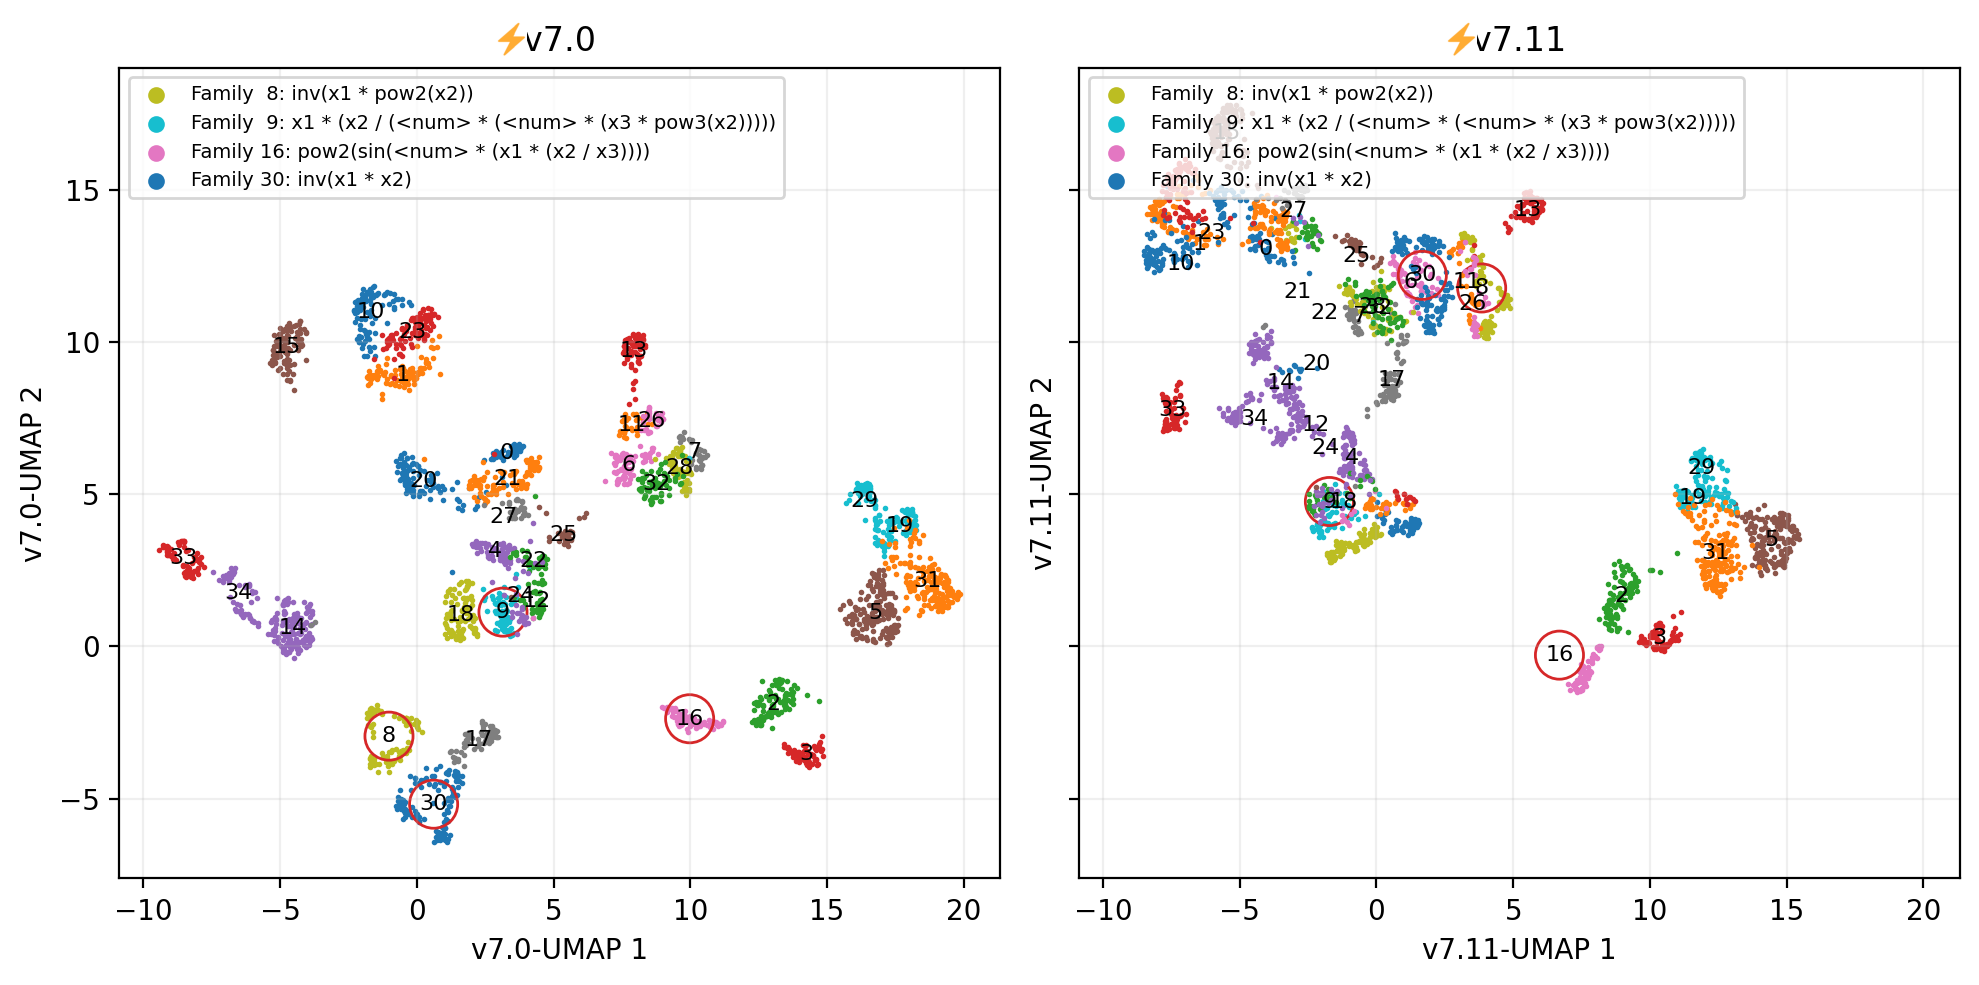

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200, sharex=True, sharey=True)

flash = plt.imread(get_path('assets', 'flash.png'))


for j, ax, (model_key, umap_model) in zip(range(2), axes, umaps.items()):
    ax.set_title(model_key)

    for i, label_index in enumerate(tqdm(set(label_indices))):
        mask = np.array(label_indices) == label_index
        ax.scatter(*umap_model.embedding_[mask].T, s=1, color=f'C{i}', label = f"Family {i:>2}: {dataset_test.skeleton_pool.expression_space.prefix_to_infix(idx_to_label[i])}" if i in detailed_label_indices else None)

        centroid = np.mean(umap_model.embedding_[mask], axis=0)
        ax.text(*centroid, str(i), fontsize=8, color=f'k', ha='center', va='center')

        if i in detailed_label_indices:
            ax.scatter(*centroid, s=300, color=f'C{i}', marker='o', edgecolor='tab:red', facecolor='none')

    # for i, detailed_label_idx in enumerate(detailed_label_indices):
    #     formula =f"Family {detailed_label_idx:>2}: {dataset_test.skeleton_pool.expression_space.prefix_to_infix(idx_to_label[detailed_label_idx])}"
    #     ax.annotate(formula, xy=(0.1, 0.95 - i * 0.05), xycoords='axes fraction', ha='left', va='top', fontsize=7, color=f'C{i}')

    ax.legend(
        loc="upper left",
        fontsize=7,
        markerscale=5.
    )

    ax.grid(alpha=0.2)

    # Create a new image with the flash.png image
    # Apparently there is no feasable way to write emojis in matplotlib WTF?!
    ax_image = fig.add_axes([0.23, 0.937, 0.038, 0.038], anchor='NE', zorder=10)
    ax_image.imshow(flash)
    ax_image.axis('off')

    
    ax_image = fig.add_axes([0.705, 0.937, 0.038, 0.038], anchor='NE', zorder=10)
    ax_image.imshow(flash)
    ax_image.axis('off')

    ax.set_xlabel(f'{model_key}-UMAP 1')
    ax.set_ylabel(f'{model_key}-UMAP 2')

fig.tight_layout()

# plt.savefig(get_path('results', 'embedding_consistency', filename=f'UMAP_comparison_v7.0_v8.0.svg'))

---

In [12]:
assert False
model = Encoder().to(device)
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-4, weight_decay=1e-2)

AssertionError: 

In [7]:
loss_fn = ContrastiveLoss(margin=0, temperature=0.5)

n_per_equation = 4
batch_size = 128

history = defaultdict(list)

alpha = 0.999
running_loss = None
steps = 100_000
val_every_steps = 100
last_val_loss = None

pbar = tqdm(total=steps)

for b, batch in enumerate(dataset_train.iterate(steps=steps, batch_size=batch_size, n_per_equation=n_per_equation)):
    model.train()
    optimizer.train()
    optimizer.zero_grad()
    input_ids, x_tensor, y_tensor, labels, constants, skeleton_hashes = FlashANSRDataset.collate_batch(batch, device)

    # Pad the x_tensor with zeros to match the expected maximum input dimension of the set transformer
    pad_length = model.flash_ansr_model.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
    if pad_length > 0:
        x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)

    # Concatenate x and y tensors as input to the set transformer
    data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)

    # Forward pass
    output = model(data_tensor)
    loss = loss_fn(output, skeleton_hashes)

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Backward pass
    loss.backward()
    optimizer.step()

    history['loss'].append(loss.item())
    history['_step'].append(b)

    if running_loss is None:
        running_loss = loss.item()
    else:
        running_loss = alpha * running_loss + (1 - alpha) * loss.item()

    if b % val_every_steps == 0:
        model.eval()
        optimizer.eval()
        val_losses = []
        with torch.no_grad():
            for val_batch in dataset_val.iterate(steps=10, batch_size=batch_size, n_per_equation=n_per_equation):
                input_ids, x_tensor, y_tensor, labels, constants, skeleton_hashes = FlashANSRDataset.collate_batch(val_batch, device)
                pad_length = model.flash_ansr_model.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
                if pad_length > 0:
                    x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)
                data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)
                output = model(data_tensor)
                val_losses.append(loss_fn(output, skeleton_hashes).item())
        history['val_loss'].append(np.mean(val_losses))
        last_val_loss = history['val_loss'][-1]
    else:
        history['val_loss'].append(np.nan)

    pbar.set_postfix_str(f"Train: {running_loss:.4f}, Val: {last_val_loss:.4f}")
    pbar.update()

  7%|▋         | 7416/100000 [19:27<4:23:44,  5.85it/s, Train: 2.6540, Val: 2.6514] 

KeyboardInterrupt: 

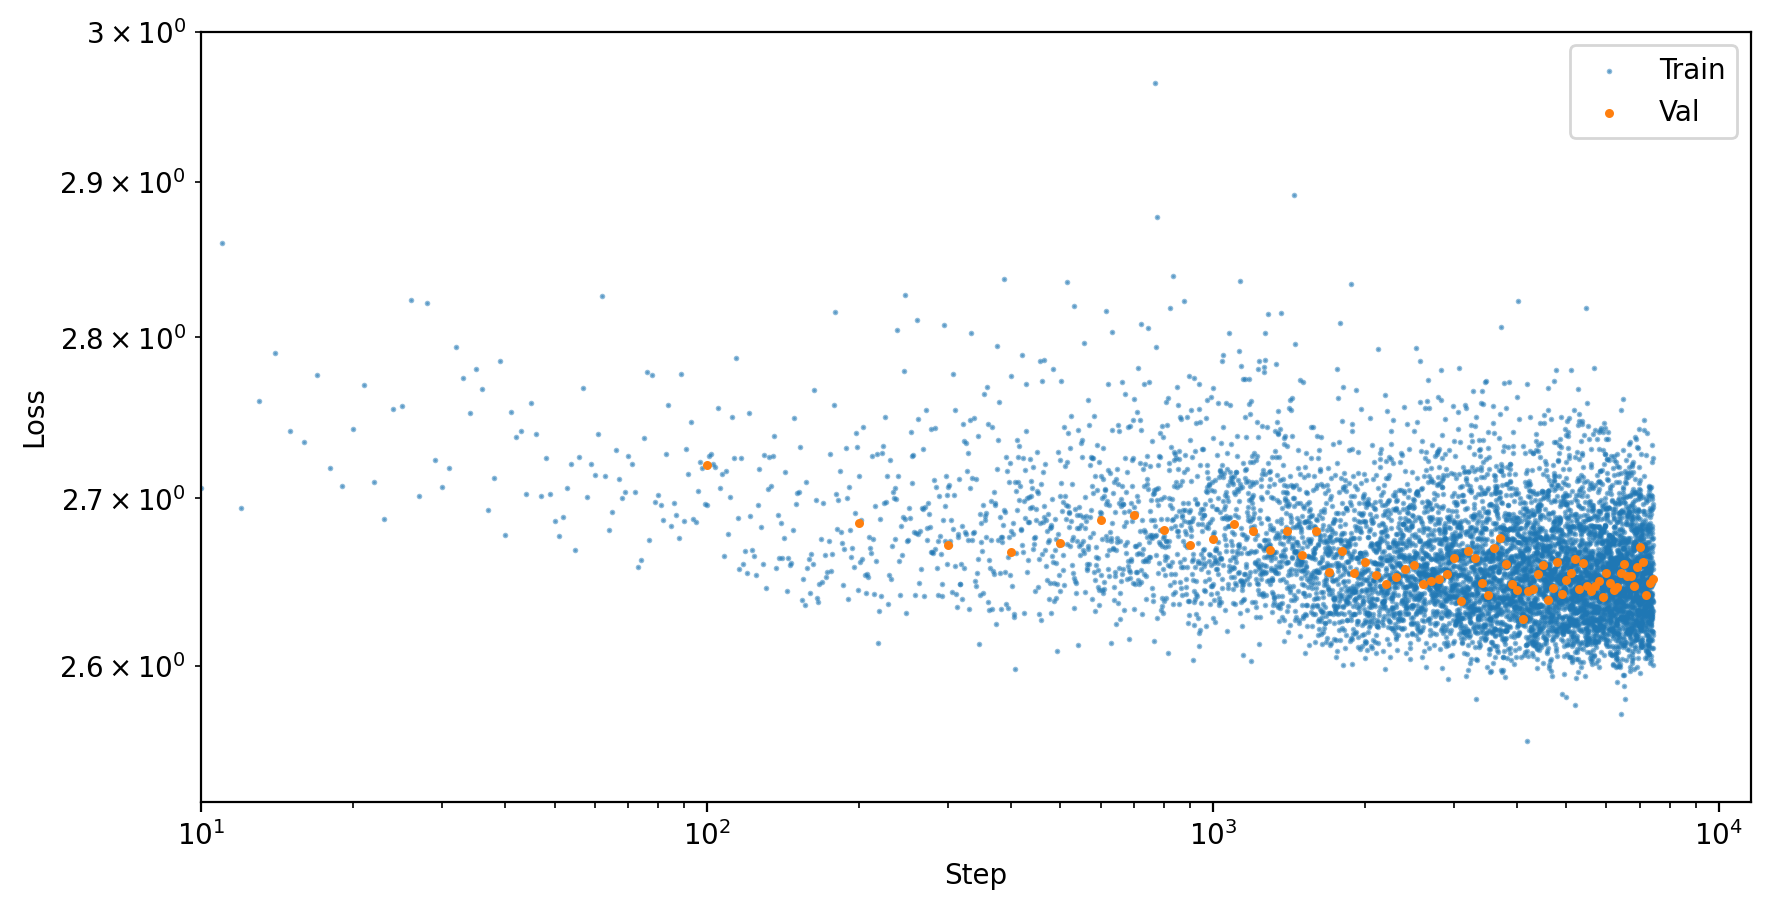

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
w = 101

# ax.plot(smooth_w_boundaries(history['_step'], w), smooth_w_boundaries(np.sqrt(history['loss']), w), label='RMS')
# valid_mask = np.isfinite(history['val_loss'])
# ax.plot(smooth_w_boundaries(np.array(history['_step'])[valid_mask], 5), smooth_w_boundaries(np.sqrt(np.array(history['val_loss'])[valid_mask]), 5), label='RMS')
ax.scatter(history['_step'], history['loss'], label='Train', s=1, alpha=0.5)
# ax.hist2d(history['_step'], np.sqrt(history['loss']), label='Loss', bins=100)
valid_mask = np.isfinite(history['val_loss'])
ax.scatter(np.array(history['_step'])[valid_mask], np.array(history['val_loss'])[valid_mask], label='Val', s=5)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, None)
ax.set_ylim(None, 3)
ax.legend()

In [11]:
N_TEST = 100

labels = []
embeddings = []
pretrained_embeddings = []

model.eval()
with torch.no_grad():
    for b, batch in enumerate(dataset_val.iterate(steps=N_TEST, batch_size=batch_size, n_per_equation=32, verbose=True, avoid_fragmentation=False)):
        _, x_tensor, y_tensor, _, _, skeleton_hashes = FlashANSRDataset.collate_batch(batch, device)
        pad_length = pretrained_encoder.flash_ansr_model.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
        if pad_length > 0:
            x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)
        data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)

        output = model(data_tensor)
        output = output.reshape(output.shape[0], -1)
        embeddings.extend(output.cpu().numpy())
        
        pretrainedoutput = pretrained_encoder(data_tensor)
        pretrainedoutput = pretrainedoutput.reshape(pretrainedoutput.shape[0], -1)
        pretrained_embeddings.extend(pretrainedoutput.cpu().numpy())

        labels.extend(skeleton_hashes)

Batch generating data: 100%|██████████| 100/100 [00:12<00:00,  8.09b/s, reject_rate=2.63%]


In [12]:
few_n = 1280 * 2

few_embeddings = embeddings[:few_n]
few_pretrained_embeddings = pretrained_embeddings[:few_n]
few_labels = labels[:few_n]

In [13]:
umap = UMAP(n_components=2, verbose=True, n_neighbors=32, metric='cosine', min_dist=0.5).fit(few_embeddings)
pretrained_umap = UMAP(n_components=2, verbose=True, n_neighbors=32, metric='cosine', min_dist=0.5).fit(few_pretrained_embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.5, n_neighbors=32, verbose=True)
Sun Feb  2 10:34:39 2025 Construct fuzzy simplicial set
Sun Feb  2 10:35:42 2025 Finding Nearest Neighbors
Sun Feb  2 10:35:47 2025 Finished Nearest Neighbor Search
Sun Feb  2 10:35:49 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Feb  2 10:35:50 2025 Finished embedding
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.5, n_neighbors=32, verbose=True)
Sun Feb  2 10:35:50 2025 Construct fuzzy simplicial set
Sun Feb  2 10:36:54 2025 Finding Nearest Neighbors
Sun Feb  2 10:36:54 2025 Finished Nearest Neighbor Search
Sun Feb  2 10:36:54 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Feb  2 10:36:55 2025 Finished embedding


In [14]:
label_to_idx = {label: idx for idx, label in enumerate(set(few_labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
label_indices = [label_to_idx[label] for label in few_labels]

In [15]:
# detailed_label_indices = [20, 9, 31]
detailed_label_indices = [7, 0, 29]

100%|██████████| 80/80 [00:00<00:00, 1443.24it/s]


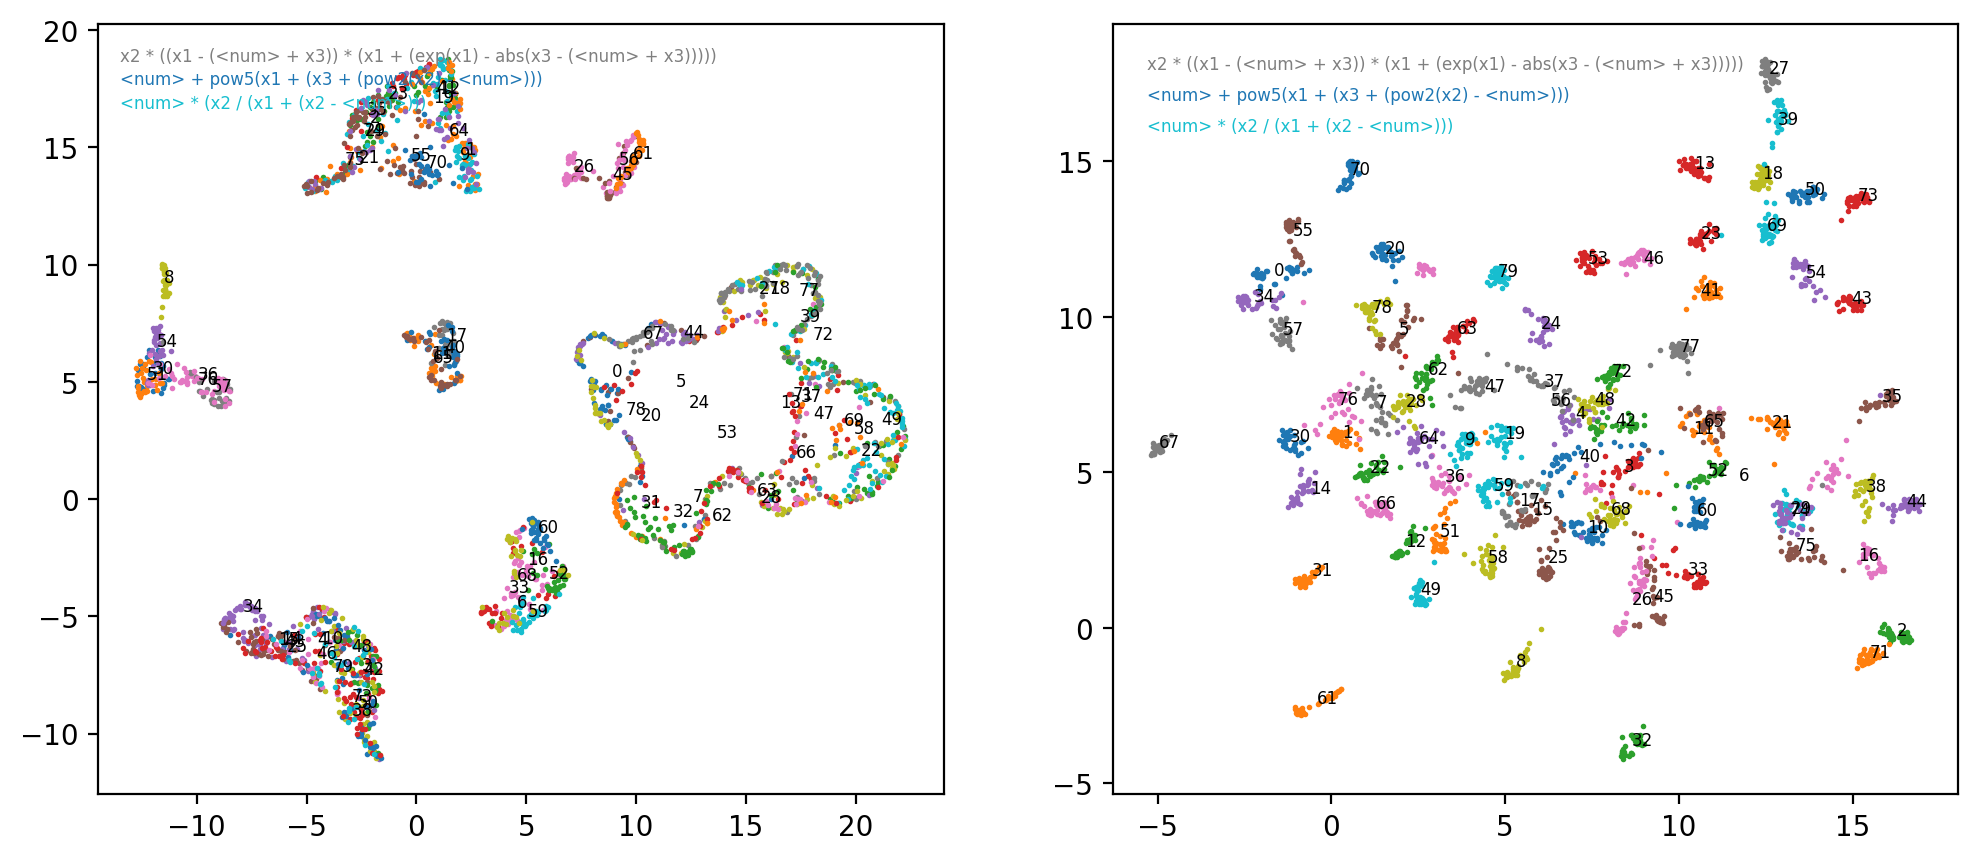

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

for j, ax, umap_model in zip(range(2), axes, [umap, pretrained_umap]):

    for i, label_index in enumerate(tqdm(set(label_indices))):
        mask = np.array(label_indices) == label_index
        ax.scatter(*umap_model.embedding_[mask].T, s=1, color=f'C{i}')

        centroid = np.mean(umap_model.embedding_[mask], axis=0)
        ax.text(*centroid, str(i), fontsize=6, color=f'k')

    for i, detailed_label_idx in enumerate(detailed_label_indices):
        ax.text(ax.get_xlim()[0] + 1, ax.get_ylim()[1] - i - 1, dataset_val.skeleton_pool.expression_space.prefix_to_infix(idx_to_label[detailed_label_idx]), fontsize=6, color=f'C{detailed_label_idx}', ha='left', va='top')

# Hyperparameter Sweep

In [7]:
# temperature_list = [2, 1, 0.5, 0.2, 0.1, 0.05]
# margin_list = [1, 0.5, 0.2, 0.1, 0.05, 0.01, 0.05]

temperature_list = [1, 0.5, 0.1]
margin_list = [1, 0.5, 0.05]

print(f'Number of combinatios: {len(temperature_list) * len(margin_list)}')

Number of combinatios: 9


In [ ]:
n_per_equation = 4
batch_size = 128

alpha = 0.999
running_loss = None
steps = 10_000
val_every_steps = 100
last_val_loss = None

histories = {}
models = {}

for temperature in temperature_list:
    for margin in margin_list:
        model = Encoder().to(device)
        optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-4, weight_decay=1e-2)
        loss_fn = ContrastiveLoss()

        history = defaultdict(list)

        pbar = tqdm(total=steps)

        for b, batch in enumerate(dataset_train.iterate(steps=steps, batch_size=batch_size, n_per_equation=n_per_equation)):
            model.train()
            optimizer.train()
            optimizer.zero_grad()
            input_ids, x_tensor, y_tensor, labels, constants, skeleton_hashes = FlashANSRDataset.collate_batch(batch, device)

            # Pad the x_tensor with zeros to match the expected maximum input dimension of the set transformer
            pad_length = model.flash_ansr_model.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
            if pad_length > 0:
                x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)

            # Concatenate x and y tensors as input to the set transformer
            data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)

            # Forward pass
            output = model(data_tensor)
            loss: torch.Tensor = loss_fn(output, skeleton_hashes)

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Backward pass
            loss.backward()
            optimizer.step()

            history['loss'].append(loss.item())
            history['_step'].append(b)

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = alpha * running_loss + (1 - alpha) * loss.item()

            if b % val_every_steps == 0:
                model.eval()
                optimizer.eval()
                val_losses = []
                with torch.no_grad():
                    for val_batch in dataset_val.iterate(steps=10, batch_size=batch_size, n_per_equation=n_per_equation):
                        input_ids, x_tensor, y_tensor, labels, constants, skeleton_hashes = FlashANSRDataset.collate_batch(val_batch, device)
                        pad_length = model.flash_ansr_model.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
                        if pad_length > 0:
                            x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)
                        data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)
                        output = model(data_tensor)
                        val_losses.append(loss_fn(output, skeleton_hashes).item())
                history['val_loss'].append(np.mean(val_losses))
                last_val_loss = history['val_loss'][-1]
            else:
                history['val_loss'].append(np.nan)

            pbar.set_postfix_str(f"Train: {running_loss:.4f}, Val: {last_val_loss:.4f}")
            pbar.update()

        pbar.close()
        histories[(temperature, margin)] = history
        models[(temperature, margin)] = model

  2%|▏         | 196/10000 [00:29<21:16,  7.68it/s, Train: 2.0165, Val: 2.1626]  Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f62898b1210>>
Traceback (most recent call last):
  File "/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
  3%|▎         | 271/10000 [00:42<28:32,  5.68it/s, Train: 2.0230, Val: 2.0627]  

In [ ]:
N_TEST = 100

labels = []
embeddings = defaultdict(list)

model.eval()
with torch.no_grad():
    for b, batch in enumerate(dataset_val.iterate(steps=N_TEST, batch_size=batch_size, n_per_equation=32, verbose=True, avoid_fragmentation=False)):
        _, x_tensor, y_tensor, _, _, skeleton_hashes = FlashANSRDataset.collate_batch(batch, device)
        pad_length = pretrained_encoder.flash_ansr_model.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
        if pad_length > 0:
            x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)
        data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)

        for (temperature, margin), model in models.items():
            output = model(data_tensor)
            output = output.reshape(output.shape[0], -1)
            embeddings[(temperature, margin)].extend(output.cpu().numpy())

        labels.extend(skeleton_hashes)

Batch generating data: 100%|██████████| 100/100 [00:11<00:00,  8.80b/s, reject_rate=3.30%]


In [ ]:
few_n = 1280 * 2

few_embeddings = {k: embeddings[k][:few_n] for k in embeddings}
few_labels = labels[:few_n]

In [ ]:
umaps = {k: UMAP(n_components=2, verbose=True, n_neighbors=32, metric='cosine', min_dist=0.5).fit(few_embeddings[k]) for k in few_embeddings}

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.5, n_neighbors=32, verbose=True)
Sat Feb  1 17:27:57 2025 Construct fuzzy simplicial set
Sat Feb  1 17:29:03 2025 Finding Nearest Neighbors
Sat Feb  1 17:29:03 2025 Finished Nearest Neighbor Search
Sat Feb  1 17:29:03 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Feb  1 17:29:04 2025 Finished embedding
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.5, n_neighbors=32, verbose=True)
Sat Feb  1 17:29:04 2025 Construct fuzzy simplicial set
Sat Feb  1 17:30:10 2025 Finding Nearest Neighbors
Sat Feb  1 17:30:10 2025 Finished Nearest Neighbor Search
Sat Feb  1 17:30:10 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Feb  1 17:30:10 2025 Finished embedding


In [ ]:
label_to_idx = {label: idx for idx, label in enumerate(set(few_labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
label_indices = [label_to_idx[label] for label in few_labels]

In [ ]:
# detailed_label_indices = [20, 9, 31]
detailed_label_indices = [7, 0, 29]

100%|██████████| 80/80 [00:00<00:00, 1365.77it/s]


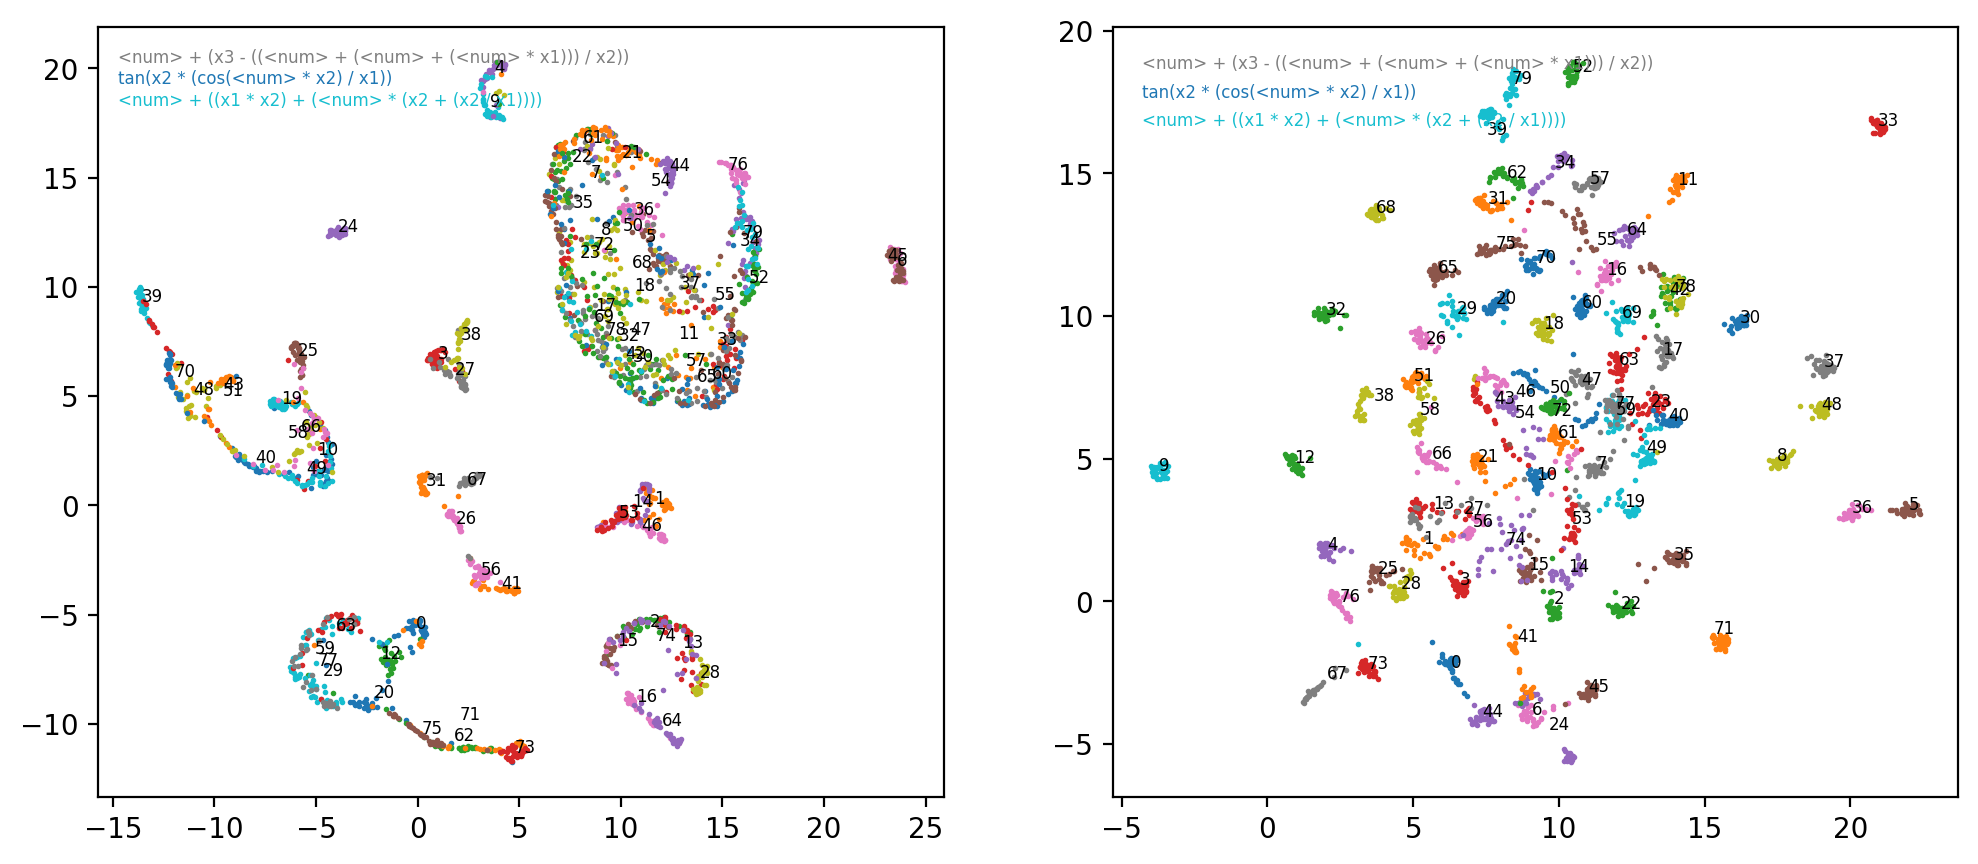

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

for j, ax, umap_model in zip(range(2), axes, [umap, pretrained_umap]):

    for i, label_index in enumerate(tqdm(set(label_indices))):
        mask = np.array(label_indices) == label_index
        ax.scatter(*umap_model.embedding_[mask].T, s=1, color=f'C{i}')

        centroid = np.mean(umap_model.embedding_[mask], axis=0)
        ax.text(*centroid, str(i), fontsize=6, color=f'k')

    for i, detailed_label_idx in enumerate(detailed_label_indices):
        ax.text(ax.get_xlim()[0] + 1, ax.get_ylim()[1] - i - 1, dataset_val.skeleton_pool.expression_space.prefix_to_infix(idx_to_label[detailed_label_idx]), fontsize=6, color=f'C{detailed_label_idx}', ha='left', va='top')

In [5]:
n_per_equation_list = [1, 2, 4, 8, 16, 32, 64, 128]

In [6]:
loss_fn = ContrastiveLoss()

In [7]:
histories = {}

for n_per_equation in n_per_equation_list:
    model = Encoder().to(device)
    optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-3, weight_decay=1e-2)

    batch_size = 128

    history = defaultdict(list)

    alpha = 0.999
    running_loss = None
    steps = 20_000
    val_every_steps = 100
    last_val_loss = None

    pbar = tqdm(total=steps)

    for b, batch in enumerate(dataset_train.iterate(steps=steps, batch_size=batch_size, n_per_equation=n_per_equation)):
        model.train()
        optimizer.train()
        optimizer.zero_grad()
        input_ids, x_tensor, y_tensor, labels, constants, skeleton_hashes = FlashANSRDataset.collate_batch(batch, device)

        # Pad the x_tensor with zeros to match the expected maximum input dimension of the set transformer
        pad_length = model.flash_ansr_model.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
        if pad_length > 0:
            x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)

        # Concatenate x and y tensors as input to the set transformer
        data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)

        # Forward pass
        output = model(data_tensor)
        loss = loss_fn(output, skeleton_hashes)

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Backward pass
        loss.backward()
        optimizer.step()

        history['loss'].append(loss.item())
        history['_step'].append(b)

        if running_loss is None:
            running_loss = loss.item()
        else:
            running_loss = alpha * running_loss + (1 - alpha) * loss.item()

        if b % val_every_steps == 0:
            model.eval()
            optimizer.eval()
            val_losses = []
            with torch.no_grad():
                for val_batch in dataset_val.iterate(steps=10, batch_size=batch_size, n_per_equation=n_per_equation):
                    input_ids, x_tensor, y_tensor, labels, constants, skeleton_hashes = FlashANSRDataset.collate_batch(val_batch, device)
                    pad_length = model.flash_ansr_model.encoder_max_n_variables - x_tensor.shape[2] - y_tensor.shape[2]
                    if pad_length > 0:
                        x_tensor = nn.functional.pad(x_tensor, (0, pad_length, 0, 0, 0, 0), value=0)
                    data_tensor = torch.cat([x_tensor, y_tensor], dim=-1)
                    output = model(data_tensor)
                    val_losses.append(loss_fn(output, skeleton_hashes).item())
            history['val_loss'].append(np.mean(val_losses))
            last_val_loss = history['val_loss'][-1]
        else:
            history['val_loss'].append(np.nan)

        pbar.set_postfix_str(f"Train: {running_loss:.4f}, Val: {last_val_loss:.4f}")
        pbar.update()

    pbar.close()
    histories[n_per_equation] = history

100%|██████████| 20000/20000 [37:37<00:00,  8.86it/s, Train: nan, Val: nan, LR: 1.00e-04] 


In [8]:
# Save the histories
import pickle
with open('histories.pkl', 'wb') as f:
    pickle.dump(histories, f)

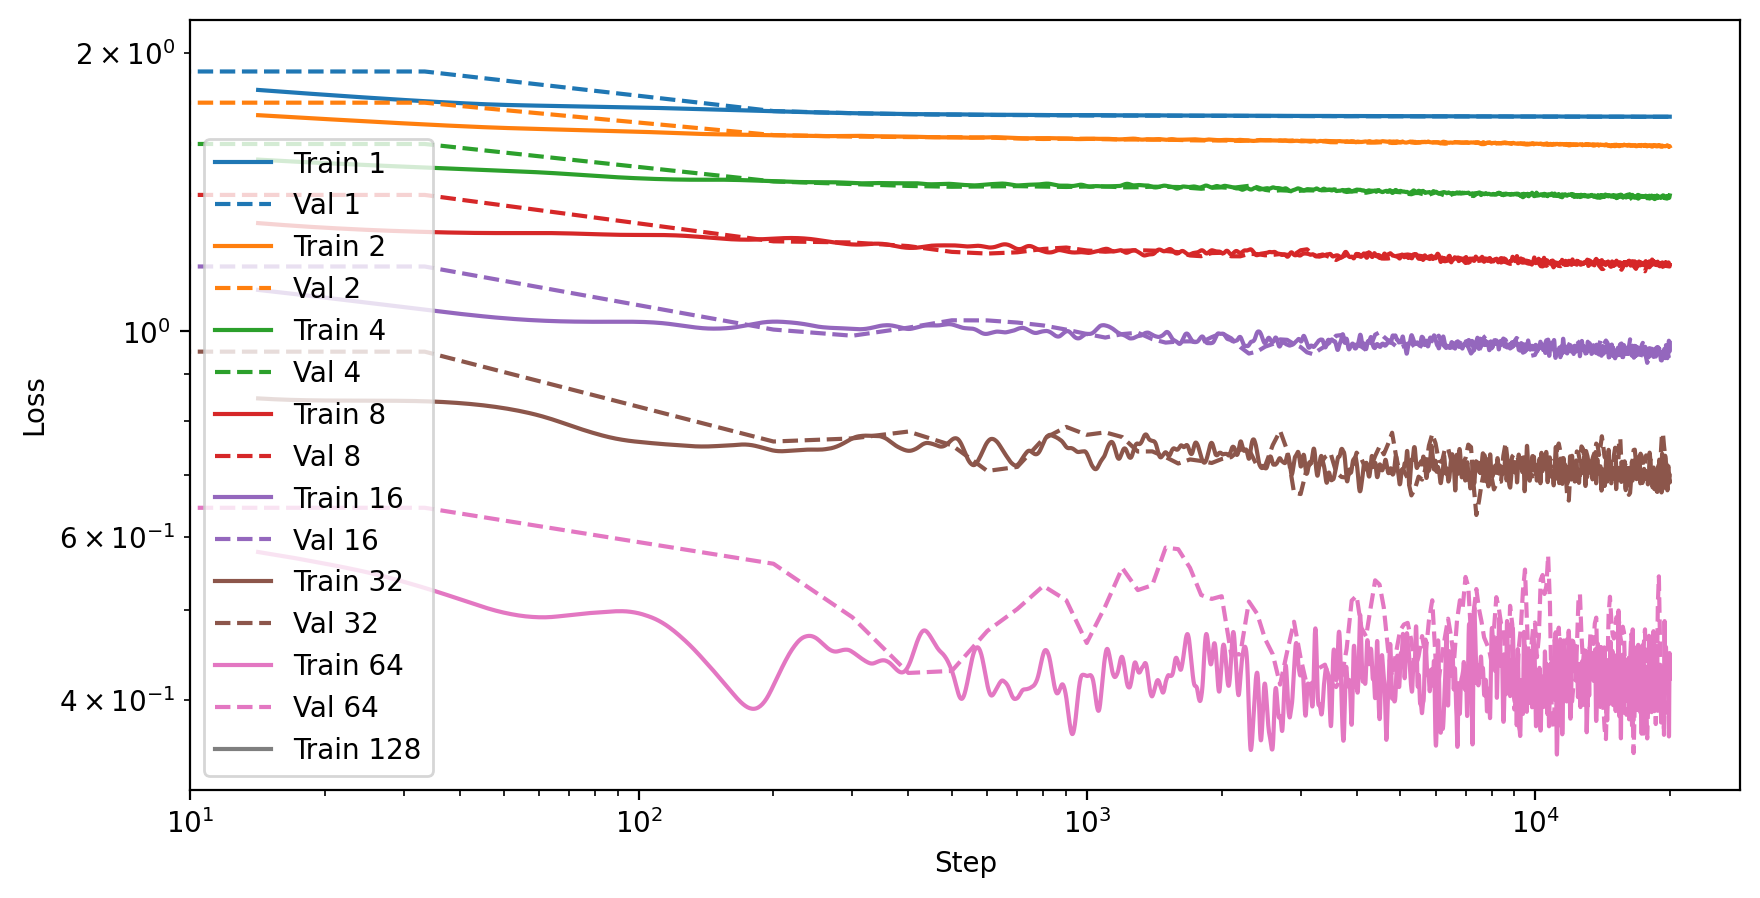

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
w = 101

for i, (n_per_equation, history) in enumerate(histories.items()):
    ax.plot(smooth_w_boundaries(history['_step'], w), smooth_w_boundaries(np.sqrt(history['loss']), w), label=f'Train {n_per_equation}', color=f'C{i}')
    valid_mask = np.isfinite(history['val_loss'])
    if not np.all(np.isnan(history['val_loss'])):
        ax.plot(smooth_w_boundaries(np.array(history['_step'])[valid_mask], 5), smooth_w_boundaries(np.sqrt(np.array(history['val_loss'])[valid_mask]), 5), label=f'Val {n_per_equation}', color=f'C{i}', linestyle='--')
# # ax.plot(smooth_w_boundaries(history['_step'], w), smooth_w_boundaries(np.sqrt(history['loss']), w), label='RMS')
# # valid_mask = np.isfinite(history['val_loss'])
# # ax.plot(smooth_w_boundaries(np.array(history['_step'])[valid_mask], 5), smooth_w_boundaries(np.sqrt(np.array(history['val_loss'])[valid_mask]), 5), label='RMS')
# ax.scatter(history['_step'], np.sqrt(history['loss']), label='Train', s=1, alpha=0.5)
# # ax.hist2d(history['_step'], np.sqrt(history['loss']), label='Loss', bins=100)
# valid_mask = np.isfinite(history['val_loss'])
# ax.scatter(np.array(history['_step'])[valid_mask], np.sqrt(np.array(history['val_loss'])[valid_mask]), label='Val', s=5)
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, None)
# ax.set_ylim(None, 1.5)
ax.legend()